# Multilayer Perceptron Assignment

**Goal:**  Learn how multilayer perceptrons operate mathematically.

* In this notebook we're going to learn how a multilayer perceptron operates.  In the process I'm going to show you how an MLP can model a function that a linear regression might struggle with.  


* Throughout this notebook there were will be some questions you'll need to turn in. These will help you get aquainted with the code. __I recommend making a copy and then spending some time running the code before answering the questions.__  


* Lastly, there are many great frameworks for building neural networks.  Because of this, it's unlikely you will ever have to go to the trouble of implementing a neural network from scratch like we are here.  We will be using one of those frameworks for the rest of the semester, but I wanted you to get the opportunity to understand how neural networks work, under the hood.  



In [97]:
# These are the packages I'll be using.
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from utils import make_meshgrid, plot_contours
from math import e
import pandas as pd
%matplotlib inline
np.random.seed(42) 

## Creating a Dataset with sklearn.datasets.make_moons
Scikit Learn has a built in binary classification toy dataset called make_moons that should be very difficult for a linear regression to classify.

Lets load it and try.

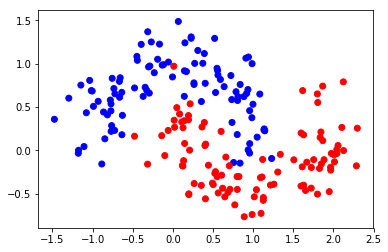

In [124]:

moons = make_moons(n_samples=200, noise=.2)  # you can experiment with more or less noise here if you'd like
X, y = moons

# plotting this dataset, positive examples will be red.
colors=['r' if item == 1 else 'b' for item in y]
plt.scatter(X[:,0], X[:,1], c=colors, cmap=plt.cm.coolwarm)
plt.show()

In [134]:
# Each row of the dataset has two featurs, x_1 and x_2.  Here are the first 5 rows.
X[0:5,:]

array([[-1.10689665e+00,  4.22928095e-02],
       [ 9.56799641e-01,  4.56750492e-01],
       [ 7.33516277e-01,  5.84617437e-01],
       [ 1.11140659e+00, -3.09213987e-01],
       [ 2.09081764e-01,  6.56679495e-04]])

In [132]:
# Each y can be either a 0 or 1.  Here are the first 5 Ys
y[0:5]

array([0, 0, 0, 1, 1])

# Logistic regression applied to the moons dataset

Here I'm going to use sklearn.linear_model.LogisticRegression to build a multivariate logistic regression on the dataset.  **Note that I'm not using hold out validation here, I'm predicting on the training set so I'm making it really really easy!**

Lets see how Logit does on the dataset

In [135]:
lr = LogisticRegression()
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Logit Accuracy: 85.5%


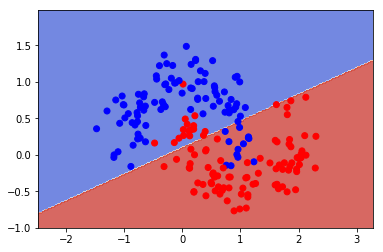

In [136]:
print("Logit Accuracy: {0}%".format(accuracy_score(y, lr.predict(X)) * 100))
xx,yy = make_meshgrid(X,y)
plot_contours(lr, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:,0], X[:,1], c=colors, cmap=plt.cm.coolwarm)


As you might expect, it's really difficult to seperate these two classes with a straight line. 

Now lets use a MLP instead.

# Multilayer Perceptron

This implementation of an MLP is heavily inspired by Andrew Ng's excellent [deeplearning.ai](https://www.deeplearning.ai/) program.  It's meant to be a learning example.  Hopefully you'll find it easy to read and understand.

I've implemented the MLP accross several functions you'll see below.  Before each function I'll explain it.

## Sigmoid
this is an implementation of the sigmoid activation function, which you've already seen in the lecture.

In [137]:
def  sigmoid(z):
         return 1/(1+e**-z)

## Initialize Parameters
This function is going to initialize the matricies for all the neuron weights to random numbers.  Random initialization is very important, if we initialized every weight to the same value then the network won't learn properly. See DLQR page 53 for more information if you'd like to know why.

This neural network implementation will be completely vectorized, so hopefully you brushed up on your linear algebra last week.

For example, W1, the weight matrix for the first network layer, will be of shape (num_hidden_layer_neurons, num_input_features).   In our example I'm going to use 10 hidden layer neurons, so that means W1 will be a 10 by 2 matrix.  



In [148]:
def initialize_parameters(num_input_features, num_hidden_layer_neurons, num_output_neurons):    
    W1 = np.random.randn(num_hidden_layer_neurons, num_input_features) * 0.01
    b1 = np.zeros((num_hidden_layer_neurons, 1))
    W2 = np.random.randn(num_output_neurons, num_hidden_layer_neurons) * 0.01
    b2 = np.zeros((num_output_neurons, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

## Forward Propagation and Backwards Propigation Overview
Remember training a neural network involves two steps, forward propagation and backwards propagation.

In forward propagation we have the network calculate it's prediction for the training data.  Then, in backwards propagation we propagate the derivative of the error w.r.t. each parameter back through the network, adjusting our weights to be more correct as we go.

### Forward Propagation
In this function we're implementing the forward propigation step.

We start with X.  We then apply the linear part of the neural network by computing Z1.  A1 is then the result of Z1 when we apply a nonlinearity.  In this case we're using hyperbolic tangent.



In [140]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

### Homework Question 1:
For W1, b1, W2, b2, Z1, A1, Z2, and A2 what are the shapes of each matrix in this example?

### Cost Function
This is the logistic cost function.  We haven't covered it yet, but we will soon.  All you need to know for now is that it measures error so given y_hat (the network's prediction) and y, it will output a number allows us to know how well the network is performing.  A loss of 0 would indicate that y_hat == y.

In [151]:
def compute_cost(y_hat, y, parameters):
    m = y.shape[1] # number of examples
    logprobs = np.dot(np.log(y_hat), y.T) + np.dot(np.log(1-y_hat), (1 - y).T)
    cost = -1/m * np.sum(logprobs)    
    cost = np.squeeze(cost)
    return cost

### Backward Propagation
For the network to learn we need to compute the derivatives of the function we previously implemented in forward propigation.  Luckily for us we can use the chain rule of calculus to solve the problem by breaking the overall function into it's constituent steps.

I've computed those derivatives for you below.  The neural network frameworks that we use for the remainder of the class do this automatically for you.  So, there is no need for you to know how to do these calculations.

What's important is that you understand WHAT is happening here.

In [152]:
def backward_propagation(parameters, cache, X, y):
    m = X.shape[1]
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']

    dZ2= A2 - y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2)  * (1 - np.power(A1, 2))
    dW1 =  1/m * np.dot(dZ1,X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

### Homework Question 2:
For dZ2, dW2, db2, dZ1, dW1, and db1, what are the shapes of each matrix in this example?

### Homework Question 3:
Why do we compute the gradients backwards from A2 to X?

### Update Parameters

In this function we're implementing one step of gradient descent.  As you recall from page 13 of DLQR, gradient descent works by nudging the values of $\theta$ in the correct direction by adjusting them by the gradient * some learning rate $\alpha$.

$$ \theta = \theta - \alpha \frac{\partial{J}}{\partial{\theta}}$$

Our goal in doing this is to minimize the cost function so that the network is as correct as possible.  By using the derivative of each individual $\theta$ we can be sure we are moving the value of $\theta$ in the proper direction and with the propper 'step size.'

In [153]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

## Train Network
Train network puts together all the previous functions.

Inside we setup a loop that runs for some number of iterations.  (Side note: In this case each iteration is also an 'epoch' in neural network speak because we are passing the entire training set each iteration.  Every time the NN sees the entire training set we count that as an epoch)

For each iteration we do each of these steps:  
* forward propagate the training data through the network
* compute the cost
* calculate the derivatives for each theta
* update each theta by the rule specified above

If everything works right, we should see that the cost goes down over time as the values of theta become more optimal.


In [154]:
def train_network(X, y, hidden_layer_size, num_iterations = 10000, print_cost=False):
    y=y.reshape(-1,1).T
    X=X.T
    parameters = initialize_parameters(X.shape[0], hidden_layer_size, 1)
    costs=[]
    
    for i in range(0, num_iterations):
        y_hat, cache = forward_propagation(X, parameters)
        cost = compute_cost(y_hat, y, parameters)
        costs.append(cost) # keep a log of costs, so we can visualize it later
        grads = backward_propagation(parameters, cache, X, y)
        parameters = update_parameters(parameters, grads)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return costs, parameters
    
    
    
    

## Network Training
Now I'll use the train_network function to train our network, using 10 hidden layer neurons for 30,000 iterations

In [155]:
costs, parameters = train_network(X,y,10, num_iterations=30000, print_cost=False)

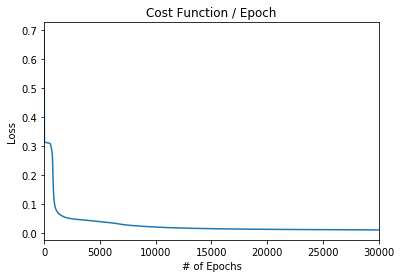

In [156]:
#Examining the cost function at each epoch will show us how well our network is learning.
plt.title("Cost Function / Epoch")
ax=pd.Series(costs).plot()
ax.set_xlabel("# of Epochs")
ax.set_ylabel("Loss")
plt.show()

## MLP Decision Boundary

Lastly lets make a prediction (forward propigate on X) and see recreate the decision boundary function we used in the logistic regression.

In [160]:
def predict(parameters, X):
    X = X.T
    y_hat, cache = forward_propagation(X, parameters)
    predictions = (y_hat > 0.5)    
    return predictions.T


In [161]:
y_hat = predict(parameters, X)

MLP Accuracy: 99.5%


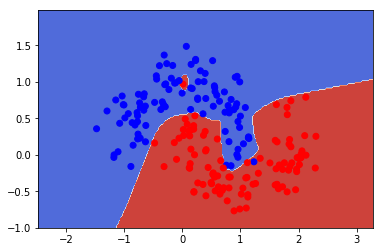

In [163]:
print("MLP Accuracy: {0}%".format(accuracy_score(y, y_hat) * 100))
xx,yy = make_meshgrid(X,y)

Z = predict(parameters, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
out = plt.contourf(xx, yy, Z,cmap=plt.cm.coolwarm)
plt.scatter(X[:,0], X[:,1], c=colors, cmap=plt.cm.coolwarm)
plt.show()

## Results

We can see that the Neural Network is able to create a decision boundary around the moons much better than the linear regression.  And it should.  It has WAY more parameters than the linear regression.

### Homework Question 4:  
How many parameters does the Neural Network we built have?  How many does the original linear regression have?


### Homework Question 5:
Modify the original neural network such that you can add a second hidden layer.